# *dandelion* Notebook-3
![dandelion_logo](img/dandelion_logo.png)

## BCR clustering and visualization

Now that we have both 1) a pre-processed BCR data and 2) matching `AnnData` object, we can start finding clones and *'integrate'* the results. I'm using quotations for the integration because it's only a pseudo-operation in this case. All the BCR analyses files remain accessible externally in *.tsv* format so that it can be used in other tools like *immcantation*, *immunoarch*, *vdjtools*, *bcrep* etc., and only a few items will be added to the `AnnData` object, mainly for visualization purposes.

On the topic of finding clones, there are many ways used for identifying BCR clones, almost all involving some measure based on sequence similarity. There are also a lot of very well established guidelines and criterias maintained by the BCR community. For example, *immcantation* uses a number of model-based [methods](https://changeo.readthedocs.io/en/stable/methods/clustering.html) to group clones based on the distribution of length-normalised junctional hamming distance while [rbr1](https://www.well.ox.ac.uk/research/research-groups/bashford-rogers) developed a method to use the whole BCR VDJ sequence to define clones as shown in this recent [paper](https://www.nature.com/articles/s41586-019-1595-3.pdf). While these methods have mainly been applied to bulk BCR-seq protocols, they are biological grounded and should be applicable to single cells, as shown in immcantation's [method](https://changeo.readthedocs.io/en/stable/examples/10x.html).

### Finding clones

The following is *dandelion*'s implementation of a function to define clones, `tl.find_clones`. 

Clone definition is based on the following criterias:

    (1) Identical IGH V-J gene usage.

    (2) Identical junctional sequence length.

    (3) Junctional sequences attains a minimum of % sequence similarity, based on hamming distance. The similarity cut-off is tunable (default is 85%).

    (4) Light chain usage. If cells within clones use different light chains, the clone will be splitted following the same conditions for heavy chains in (1-3) as above. 

The 'clone' name follows a `{A}_{B}_{C}_{D}` format and largely reflects the conditions above where:

    {A} indicates if the contigs use the same IGH V/J genes.
    
    {B} indicates if IGH junctional sequences are equal in length.
    
    {C} indicates if clones are splitted based on junctional hamming distance threshold
    
    {D} indicates light chain pairing. 

The last position will not be annotated if there's only one group of light chains usage detected in the clone.

So in essence, cloned flagged up in `{A}` through to `{D}` are evolutionary-related and those that actually encode productive chains in `{D}` (or `{C}`) would be functionally related.

#### Import modules

In [1]:
import os
import pandas as pd
os.chdir(os.path.expanduser('/Users/kt16/Documents/Github/dandelion'))
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Documents/Clatworthy_scRNAseq/Ondrej/PIP/'))

/Users/kt16/miniconda3/envs/dandelion/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


I will work with the same example from the previous notebook since I have the `AnnData` object saved and vdj table filtered.

#### Set up some variables

In [2]:
sample = 'Pan_T7918901'
bcr_folder = 'Pan_Immune_BCR/'
gex_folder = 'Pan_Immune_GEX/'
sampledict = ddl.utl.dict_from_table('/Users/kt16/Documents/Clatworthy_scRNAseq/Ondrej/dandelion_files/meta/PIP_sampleInfo_kt16.txt', columns = ('SANGER SAMPLE ID', 'GEX_SAMPLE_ID')) 
filtered_file = bcr_folder+sample+'/dandelion/data/all_contig_igblast_gap_genotyped_filtered.tsv'

#### Running `tl.find_clones`
The function will take a file path or a pandas dataframe (for example if you've used pandas to read in the filtered file already). The default mode for calculation of junctional hamming distance is to use the junction amino acid sequences. If you want to do it via nucleotide, you can specify the option:
```python
clustering_by = 'nt'
```

If you want to use the alleles for defining V-J gene usuage, specify:
```python
by_alleles = True
```

In [3]:
vdj_clone = ddl.tl.find_clones(filtered_file)
vdj_clone

Finding clones : 100%|██████████| 71/71 [00:00<00:00, 8617.52it/s]
Refining clone assignment based on light chain pairing : 100%|██████████| 90/90 [00:00<00:00, 1250.05it/s]


,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,np1,np1_length,np2,np2_length,junction_aa_length,c_call,cell_id,sample_id,v_call_genotyped,clone_id
sequence_id,,,,,,,,,,,,,,,,,,,,,
Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_1,Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_1,GAGGAGTCAGACCCAGTCAGGACACAGCATGGACATGAGGGTCCCC...,FALSE,TRUE,IGKV1D-12*01,NaN,IGKJ5*01,GACATCCAGATGACCCAGTCTCCATCTTCTGTGTCTGCATCTTTAG...,GACATCCAGATGACCCAGTCTCCATCTTCTGTGTCTGCATCTGTAG...,TGTCTACAGGGTGAGAGTTACCCTCTCACCTTC,...,NaN,0,NaN,NaN,11,IGKC,Pan_T7917815_ACCTTTATCGCTTGTC,Pan_T7917815,IGKV1D-12*01,46_1_1
Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_2,Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_2,AGCCTGCGAGGCGAAGATACGGCTATCTATTACTGTGCGAGTGATC...,FALSE,TRUE,"IGHV3-21*06,IGHV3-30*07,IGHV3-30*12",IGHD4-23*01,IGHJ4*02,.................................................,AATTCACTGTATCTGCAAATGAACAGCCTGAGAGCCGAGGACACNN...,TGTGCGAGTGATCCCCCTACTGCGGGAGACTACGGTGGCGGAGCCG...,...,TCCCCCTACTGCGGGA,16,CGGAGCCGAT,10,20,IGHG2,Pan_T7917815_ACCTTTATCGCTTGTC,Pan_T7917815,"IGHV3-21*06,IGHV3-30*07,IGHV3-30*12",46_1_1
Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_1,Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_1,TGGGGGAGAAGAGCTGCTCAGTTAGGACCCAGAGGGAACCATGGAA...,FALSE,TRUE,IGKV3-20*01,NaN,IGKJ1*01,GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,TGTCAGCACTTTGGTAGCTCATCCTGGACGTTC,...,TCC,3,NaN,NaN,11,IGKC,Pan_T7917815_ACTGCTCCAGGTCGTC,Pan_T7917815,IGKV3-20*01,2_1_1
Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_2,Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_2,GAGCTCTGAGAGAGGAGCCTTAGCCCTGGATTCCAAGGCCTATCCA...,FALSE,TRUE,IGHV3-21*01,IGHD4-23*01,IGHJ4*02,GAGGTGCAGTTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...,GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...,TGTGCGAGAGGAGAGCGGGCGGCGGTAACCACCTACTGG,...,GAGAGCGGG,9,CAC,3,13,IGHM,Pan_T7917815_ACTGCTCCAGGTCGTC,Pan_T7917815,IGHV3-21*01,2_1_1
Pan_T7917815_CCTACCAGTGCCTTGG-1_contig_1,Pan_T7917815_CCTACCAGTGCCTTGG-1_contig_1,AGAGAGCCCTGGGGAGGAACTGCTCAGTTAGGACCCAGAGGGAACC...,FALSE,TRUE,IGKV3-11*01,NaN,IGKJ4*01,GAGATTGTGTTGACTCAGTCTCCAGTCACCCTGTCTTTGTCTCCAG...,GAAATTGTGTTGACACAGTCTCCAGCCACCCTGTCTTTGTCTCCAG...,TGTCAGCAGCGTAGCAACTGGCCTCCGCTCACTTTC,...,NaN,0,NaN,NaN,12,IGKC,Pan_T7917815_CCTACCAGTGCCTTGG,Pan_T7917815,IGKV3-11*01,63_1_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pan_T7917815_TTGCCGTCAAGTCTGT-1_contig_2,Pan_T7917815_TTGCCGTCAAGTCTGT-1_contig_2,GGCAGAAGTCTCTCTCAGTCAGGACACAGCATGGACATGAGGGTCC...,FALSE,TRUE,IGKV1-27*01,NaN,IGKJ1*01,GACATCCAGATGACCCAGTCTCCATCCTCCCTGTCTGCATCTGTAG...,GACATCCAGATGACCCAGTCTCCATCCTCCCTGTCTGCATCTGTAG...,TGTCAAAAGTATTCCAATGTTCCCTGGACGTTC,...,TTCCC,5,NaN,NaN,11,IGKC,Pan_T7917815_TTGCCGTCAAGTCTGT,Pan_T7917815,IGKV1-27*01,24_2_1
Pan_T7917815_GTACTCCAGCCACTAT-1_contig_1,Pan_T7917815_GTACTCCAGCCACTAT-1_contig_1,GGACACCCTGTGCAGGAGTCAGACCCAGTCAGGACACAGCATGGAC...,FALSE,TRUE,"IGKV1-12*01,IGKV1-12*02,IGKV1D-12*02",NaN,IGKJ2*01,GACATCCAGATGACCCAGTCTCCATCTTCCGTGTCTGCATCTGTAG...,GACATCCAGATGACCCAGTCTCCATCTTCCGTGTCTGCATCTGTAG...,TGTCAACAGGCTAACAGTTTCCCGTACACTTTT,...,NaN,0,NaN,NaN,11,IGKC,Pan_T7917815_GTACTCCAGCCACTAT,Pan_T7917815,"IGKV1-12*01,IGKV1-12*02,IGKV1D-12*02",2_2_1
Pan_T7917815_GTACTCCAGCCACTAT-1_contig_2,Pan_T7917815_GTACTCCAGCCACTAT-1_contig_2,GAGCTCTGAGAGAGGAGCCTTAGCCCTGGATTCCAAGGCCTATCCA...,FALSE,TRUE,IGHV3-21*01,IGHD4-23*01,IGHJ4*02,GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...,GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...,TGTGCGAGTGATCCCCCTACTGCGGGAGACTACGGTGGCGGAGCCG...,...,TCCCCCTACTGCGGGA,16,CGGAGCCGAT,10,20,IGHG2,Pan_T7917815_GTACTCCAGCCACTAT,Pan_T7917815,IGHV3-21*01,2_2_1


This will return a new column in the dataframe with the column name `'clone'` as per convention. It will also save the file automatically into the base directory of the file name, or a dandelion/data folder as set up in the first notebook, with the file prefix ending with `*filtered.tsv`.

## Visualization of BCR network
To visualise the results, I took a page out of [rbr1](https://www.well.ox.ac.uk/research/research-groups/bashford-rogers)'s approach, which is to use a network-style visualisation. This uses the full V(D)J contig sequences instead of just the junctional sequences to chart a tree-like network for each clone.

I'm importing scanpy here to make use of its logging module.

In [4]:
import scanpy as sc
sc.settings.verbosity = 3

### Generate network
First we need to generate the network. The tool function `tl.generate_network` will take a V(D)J table that has clones defined, specifically under the `'clone'` column.

Again, the default mode is the use of ammino acid sequences which can be toggled to using nucleotide sequences with:
```python
distance_mode = 'nt'
```


If you have a pre-processed table parsed from immcantation's [method](https://changeo.readthedocs.io/en/stable/examples/10x.html), or any other method as long as it's in a *changeo/airr tsv* format, the table can be used as well. The main option to consider adjusting here is the `clones_sep` option; this decides how the *'grouping'* of the clones would be performed during network construction. I'm expecting the clone to be annotated with some sort of separator, such as `_`, and the `clones_sep` option takes a tuple for the position (`int`) to return after split the clone name and the type of separator (`str`), in the following format:
```python
clones_sep = (int, str)
```

So for example, if my clone is called `21-A`, then the tuple to provide to `clones_sep` would be:
```python
clones_sep = (0, '-')
```

If no appropriate separators are found, it will not split the `clone` column and will just duplicate it in the new `clone_group` column in the metadata.

In [5]:
network = ddl.tl.generate_network(vdj_clone)

Generating network


Linking edges : 100%|██████████| 100/100 [00:00<00:00, 760.47it/s]


 finished: added to dandelion class object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
   'distance', heavy and light chain distance matrices
   'edges', network edges
   'layout', network layout
   'graph', network (0:00:04)


### *dandelion_network* class object
You can see that the object that is return is a `dandelion` class object:

In [6]:
type(network).__name__

'dandelion'

Which means it has some prefilled slots, as shown in the logs above. You can retrieve these slots; for example, if I want the distance matrix:

In [7]:
network.distance

array([[ 0., 43., 43., ..., 28., 16., 40.],
       [43.,  0., 20., ..., 40., 36., 11.],
       [43., 20.,  0., ..., 40., 34., 21.],
       ...,
       [28., 40., 40., ...,  0., 21., 42.],
       [16., 36., 34., ..., 21.,  0., 35.],
       [40., 11., 21., ..., 42., 35.,  0.]])

or the meta data from the network:

In [8]:
network.metadata

,clone_id,clone_group_id,isotype,lightchain,productive,heavychain_v,lightchain_v,heavychain_j,lightchain_j
cell_id,,,,,,,,,
Pan_T7917815_ACCTTTATCGCTTGTC,46_1_1,46,IGHG2,IGKC,TRUE,"IGHV3-21*06,IGHV3-30*07,IGHV3-30*12",IGKV1D-12*01,IGHJ4*02,IGKJ5*01
Pan_T7917815_ACTGCTCCAGGTCGTC,2_1_1,2,IGHM,IGKC,TRUE,IGHV3-21*01,IGKV3-20*01,IGHJ4*02,IGKJ1*01
Pan_T7917815_CCTACCAGTGCCTTGG,63_1_1,63,IGHG3,IGKC,TRUE,IGHV4-34*02,IGKV3-11*01,IGHJ4*02,IGKJ4*01
Pan_T7917815_CGATCGGAGGGCTCTC,22_1_1,22,IGHG2,IGKC,TRUE,"IGHV1-69*01,IGHV1-69D*01",IGKV3-20*01,IGHJ4*02,IGKJ4*01
Pan_T7917815_CGGACGTTCTTTAGGG,56_2_1,56,IGHG2,IGKC,TRUE,"IGHV4-59*01,IGHV4-59*02,IGHV4-59*07","IGKV1-39*01,IGKV1D-39*01",IGHJ5*02,IGKJ2*01
...,...,...,...,...,...,...,...,...,...
Pan_T7917815_GCAGCCAAGTATTGGA,36_1_1,36,IGHG1,IGKC,TRUE,"IGHV4-28*01,IGHV4-28*02,IGHV4-28*05",IGKV3-15*01,IGHJ4*02,IGKJ4*01
Pan_T7917815_GTACTCCGTAGTAGTA,30_1_1,30,NaN,IGLC3,TRUE,IGHV2-5*02,IGLV3-19*01,IGHJ4*02,IGLJ3*02
Pan_T7917815_TTGCCGTCAAGTCTGT,24_2_1,24,IGHA2,IGKC,TRUE,IGHV3-49*04,IGKV1-27*01,IGHJ4*02,IGKJ1*01


## Visualizing BCR network - Part 1
With the network now generated, we can plot it with a function to call igraph's plotting module, `pl.igraph_network`.

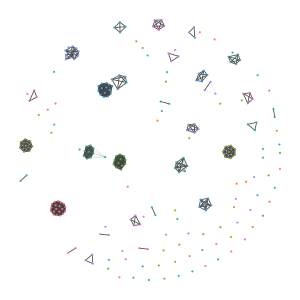

In [9]:
ddl.pl.igraph_network(network, colorby = 'clone_id')

There is a lot of information in the network construction that I think is more suited for being described in a manuscript which should really be in the process of being written, hopefully. The important thing to note is that this is a weighted network - the thickness of the edges here is inversely correlated to the distance i.e. the more similar the BCRs are between two cells, the thicker the edges.

Anyway, the plot can be further adjusted by providing the `visual_style` option with a dictionary.

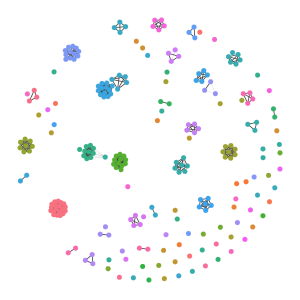

In [10]:
ddl.pl.igraph_network(network, colorby = 'clone_id', visual_style = {'vertex_size':'5'})

This plotting function contains a few default color options for each of the columns in the metadata. Again, they can be adjusted as long as a dictionary containing color mappings is provided to the `visual_style` option.

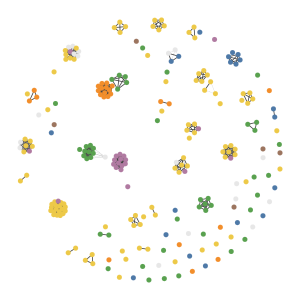

In [11]:
ddl.pl.igraph_network(network, colorby = 'isotype', visual_style = {'vertex_size':'5'})

Unfortunately this sample isn't a great example for showing whether clones are made up of non-productive and productive contigs because all of them are productive. But nevertheless, maybe with a different sample, we might have a better chance there.

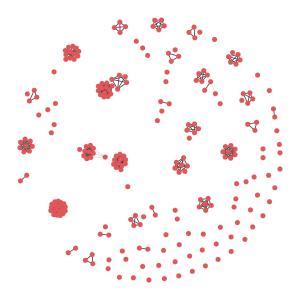

In [12]:
ddl.pl.igraph_network(network, colorby = 'productive', visual_style = {'vertex_size':'5'})

In both `generate_networks` and `pl.igraph_network`, you can change the layout option, for example:

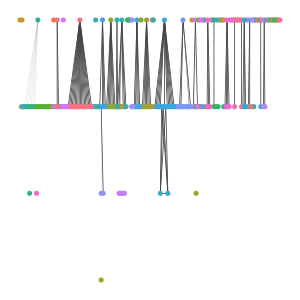

In [13]:
ddl.pl.igraph_network(network, colorby = 'clone_id', layout = 'sugiyama', visual_style = {'vertex_size':'5'})

One last thing to note before we continue to the next section : the igraph network can be accessed through the `.graph` slot in the `dandelion_class` object if you want to extract the data for network statistics or make any changes to the network.

In [14]:
network.graph

## Visualizing BCR network - Part 2
The networks can also be ported into the `AnnData` object for access to more plotting functions provided through *scanpy*.

In [15]:
import warnings

warnings.filterwarnings('ignore')
sc.logging.print_versions()
adata = sc.read_h5ad(bcr_folder+sample+'/dandelion/data/adata.h5ad')
adata

scanpy==1.4.6 anndata==0.7.1 umap==0.4.2 numpy==1.18.4 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.0 statsmodels==0.11.1 python-igraph==0.8.2


AnnData object with n_obs × n_vars = 816 × 3233 
    obs: 'sampleid', 'gender', 'donor', 'tissue', 'experiment', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'has_bcr_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

#### Initialization of scanpy object
To proceed, we first need to initialise the `AnnData` object with our network. This is done by using the tool function `tl.transfer_network`.

In [16]:
ddl.tl.transfer_network(adata, network)

Transferring network
 finished: added to `.uns['neighbors']`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix
stored original .uns in .raw (0:00:02)


You can see that `AnnData` object now contains a couple more columns in the `.obs` slot, corresponding to the metadata that is returned after `tl.generate_network`, and a newly created `X_bcr` key in the `.obsm` slot. The original `.uns` slot was also stored in `.raw` in case you want to retrieve it.

In [17]:
adata

AnnData object with n_obs × n_vars = 816 × 3233 
    obs: 'sampleid', 'gender', 'donor', 'tissue', 'experiment', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'leiden', 'clone_id', 'clone_group_id', 'isotype', 'lightchain', 'productive', 'heavychain_v', 'lightchain_v', 'heavychain_j', 'lightchain_j'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'has_bcr_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_bcr'
    varm: 'PCs'

#### Plotting in scanpy
So now, basically we can plot in scanpy with their plotting modules. I've included a plotting function in ***dandelion***, `pl.plot_network`, which is really just a wrapper of their `pl.embedding` module.

... storing 'clone_id' as categorical
... storing 'clone_group_id' as categorical
... storing 'isotype' as categorical
... storing 'lightchain' as categorical
... storing 'productive' as categorical
... storing 'heavychain_v' as categorical
... storing 'lightchain_v' as categorical
... storing 'heavychain_j' as categorical
... storing 'lightchain_j' as categorical
posx and posy should be finite values
posx and posy should be finite values


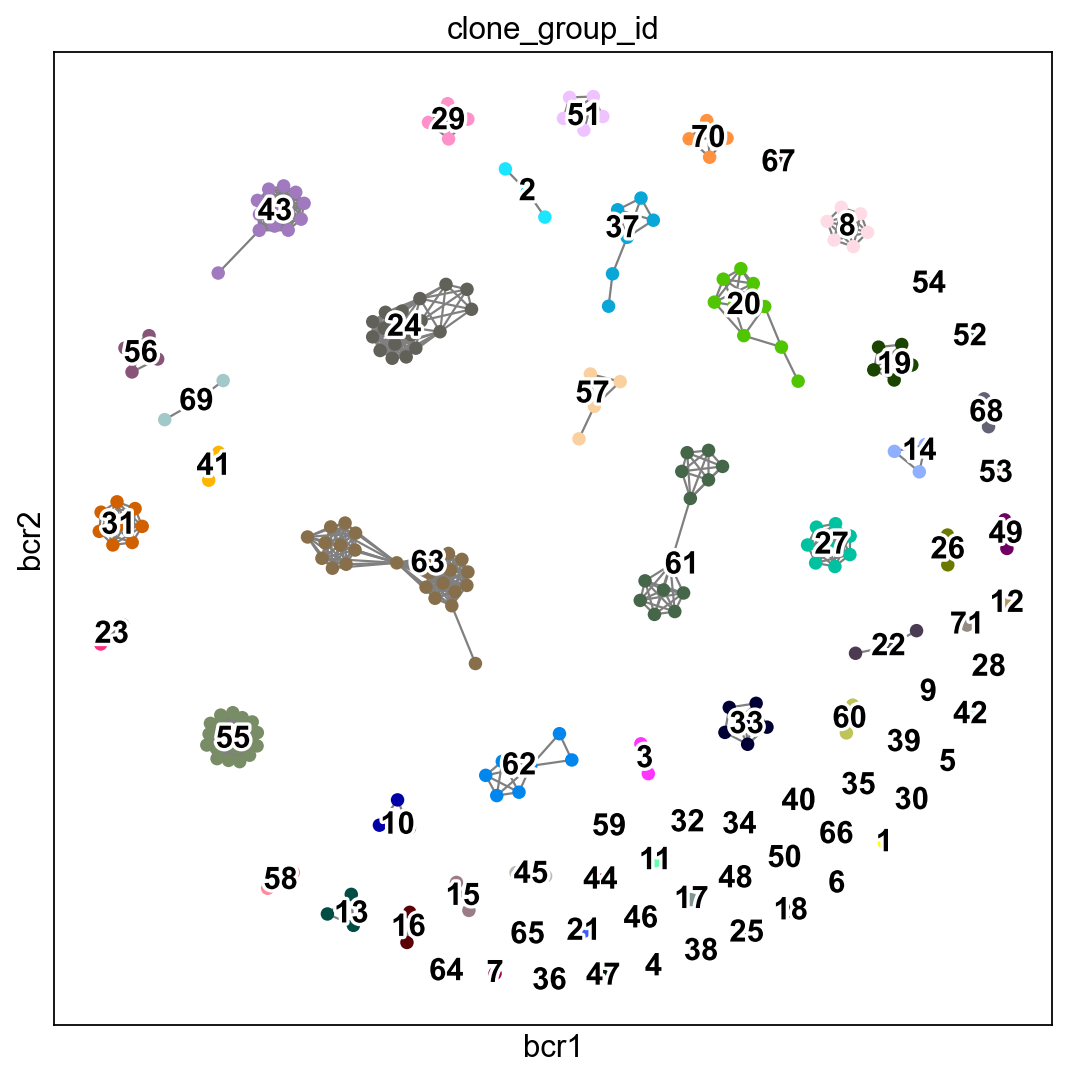

In [18]:
sc.set_figure_params(figsize = [8,8])
ddl.pl.plot_network(adata, color = ['clone_group_id'], legend_loc = 'on data', legend_fontoutline=3, edges_width = 1)

You can interact with `pl.plot_network` just as how you interact with the rest of the scatterplot modules in scanpy.

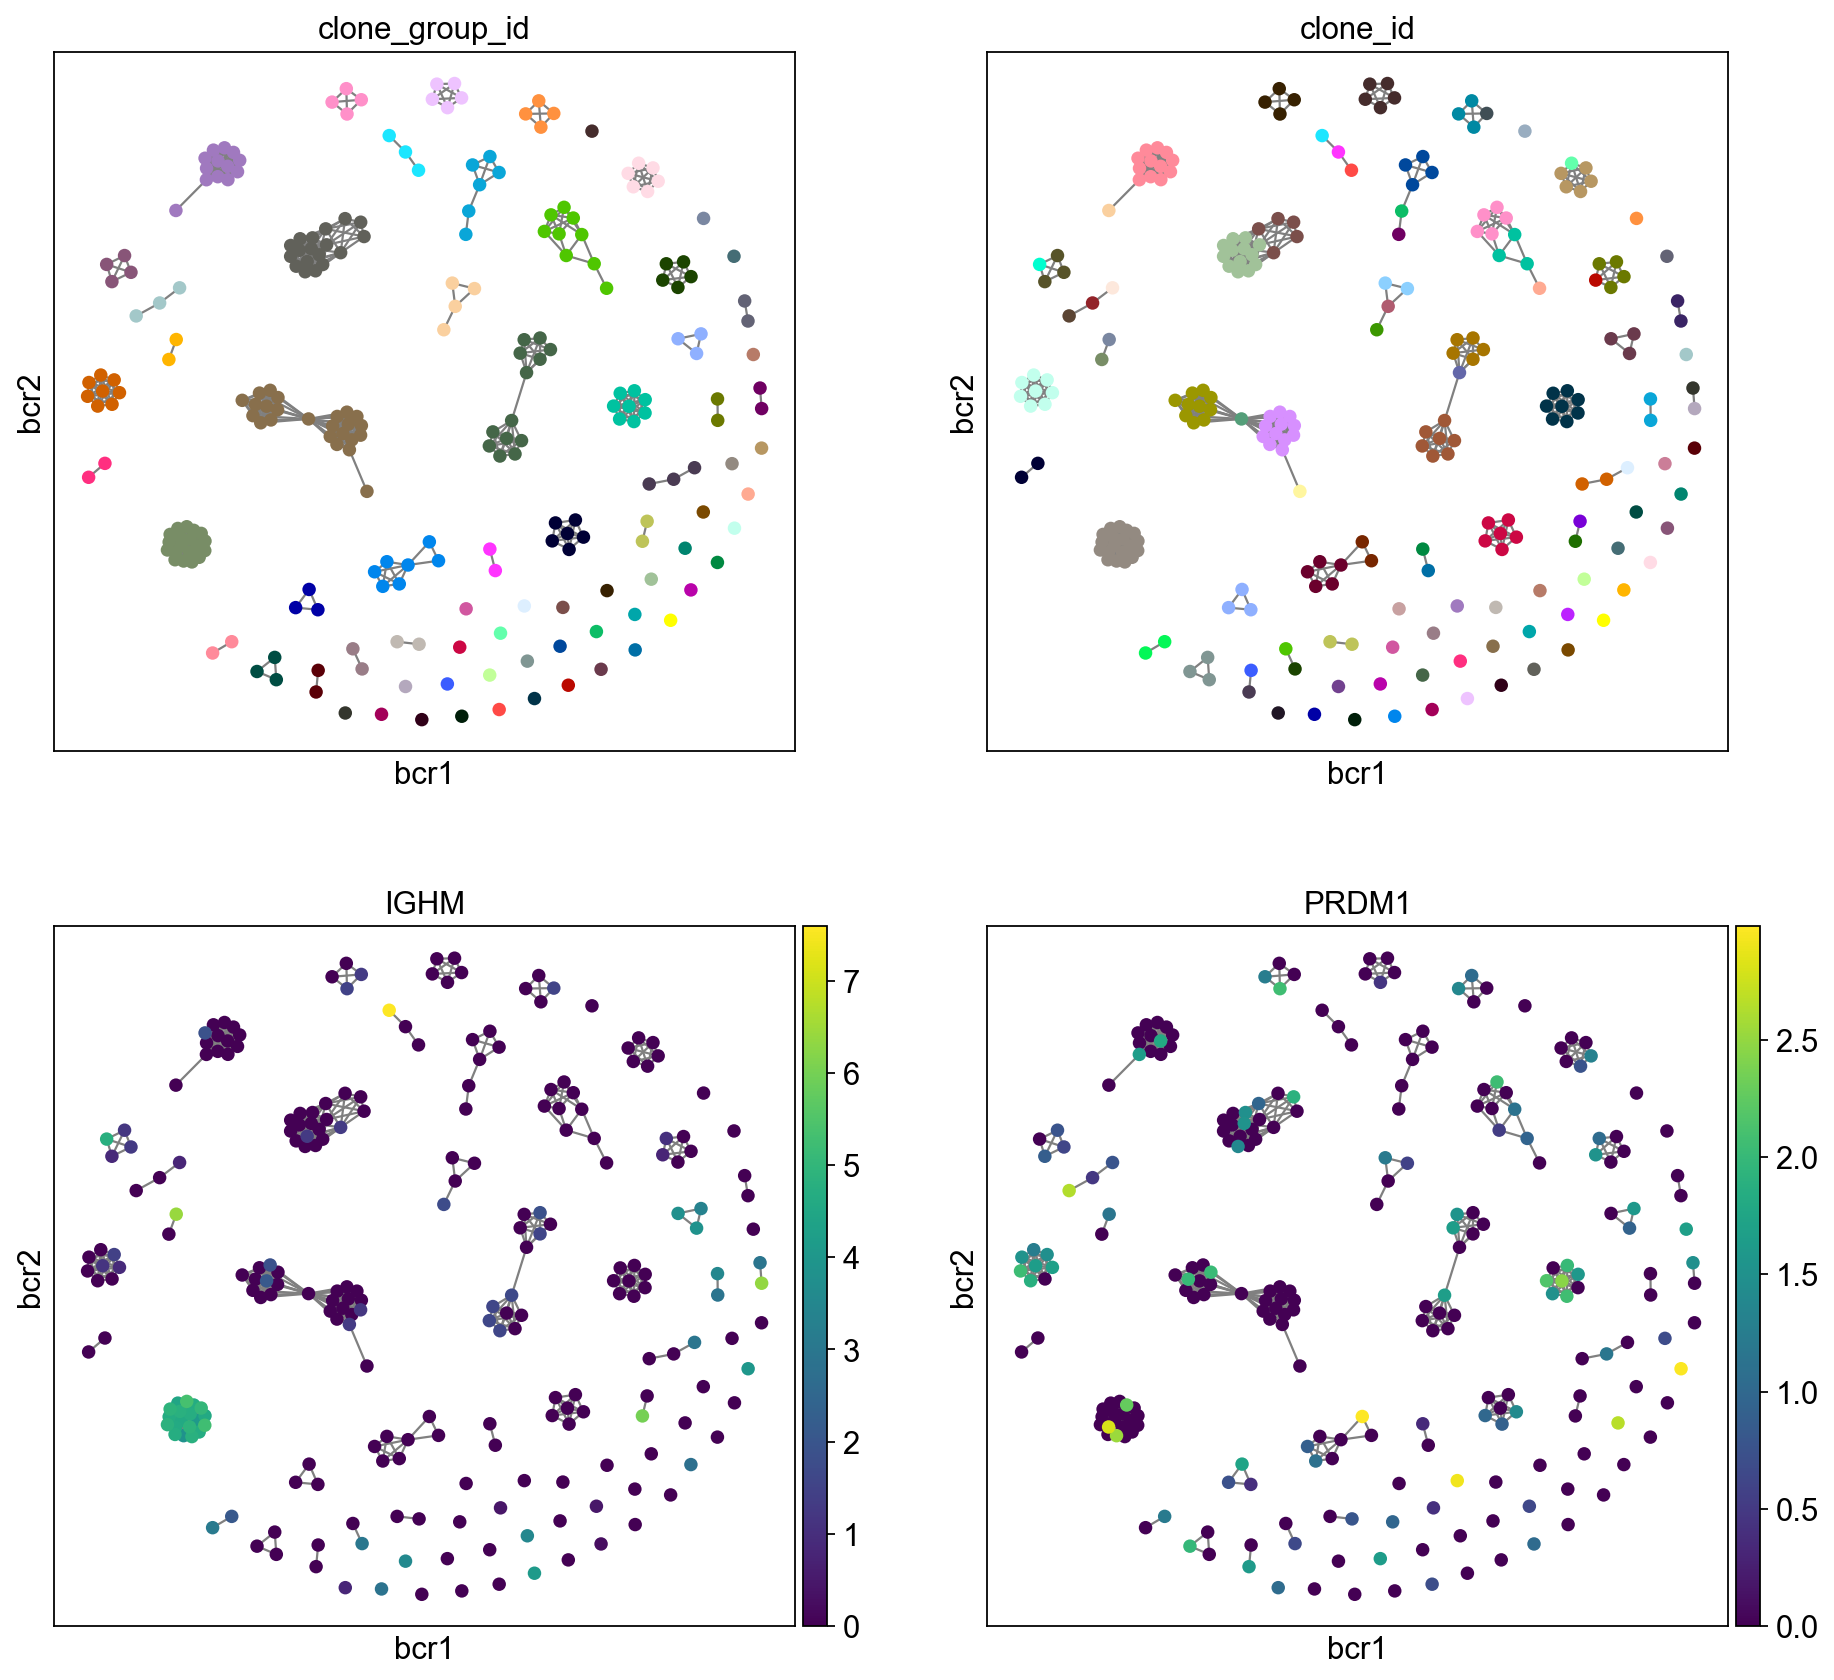

In [19]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.plot_network(adata, color = ['clone_group_id', 'clone_id', 'IGHM', 'PRDM1'], ncols = 2, legend_loc = 'none', legend_fontoutline=3, edges_width = 1)

Compared to plots in umap, I think this visualisation is a bit more useful for looking at BCR clones.

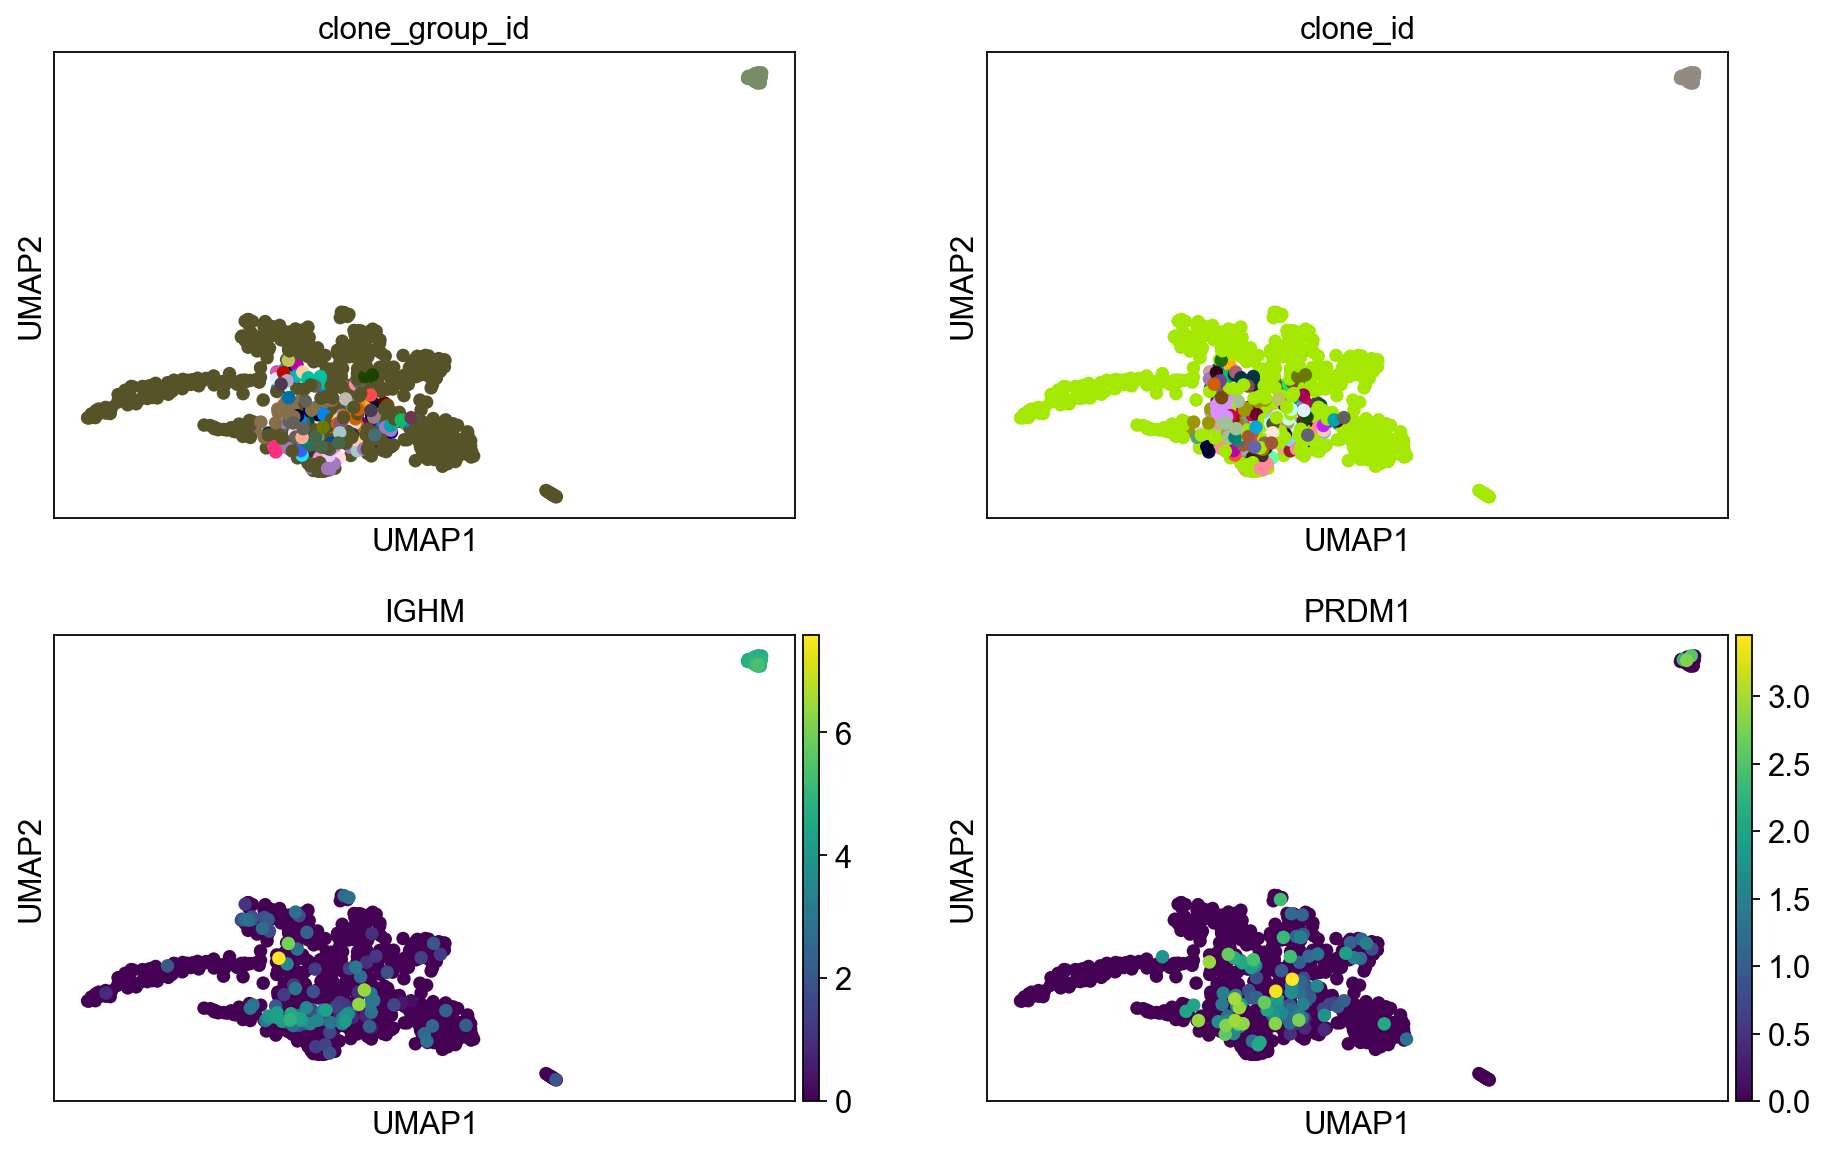

In [20]:
sc.set_figure_params(figsize = [6,4])
sc.pl.umap(adata, color = ['clone_group_id', 'clone_id', 'IGHM', 'PRDM1'], ncols = 2, legend_loc = 'none', legend_fontoutline=3, edges_width = 1)

### Calculating mutational load
To calculate mutational load, I've ported the functions from changeo and shazam to work with the `dandelion` class object.

We first need to mask the D genes from the germline sequences with the tools function `tl.create_germlines`. Then we calculate the observed mutations with `tl.quantify mutations`. The options for quantify_mutations are the same as the basic mutational load analysis [vignette](https://shazam.readthedocs.io/en/version-0.1.8---mutation-profiling-enhancements/vignettes/Mutation-Vignette/). The default behavior is to sum all mutations for the same cell.

In [21]:
ddl.tl.create_germlines(network)
ddl.tl.quantify_mutations(network)

Building germline sequences : 459it [00:00, 545.42it/s]


For example, if you want to split the calculation up between replacement (R) and silent (S) mutations, specify `combine = False`.

In [22]:
ddl.tl.quantify_mutations(network, combine = False)

To update the AnnData object, simply rerun `tl.transfer_network`

In [23]:
ddl.tl.transfer_network(adata, network)

Transferring network
 finished: added to `.uns['neighbors']`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix
stored original .uns in .raw (0:00:02)


You can now visualise the mutation rate on via the plotting modules.

... storing 'clone_id' as categorical
... storing 'clone_group_id' as categorical
... storing 'isotype' as categorical
... storing 'lightchain' as categorical
... storing 'productive' as categorical
... storing 'heavychain_v' as categorical
... storing 'lightchain_v' as categorical
... storing 'heavychain_j' as categorical
... storing 'lightchain_j' as categorical


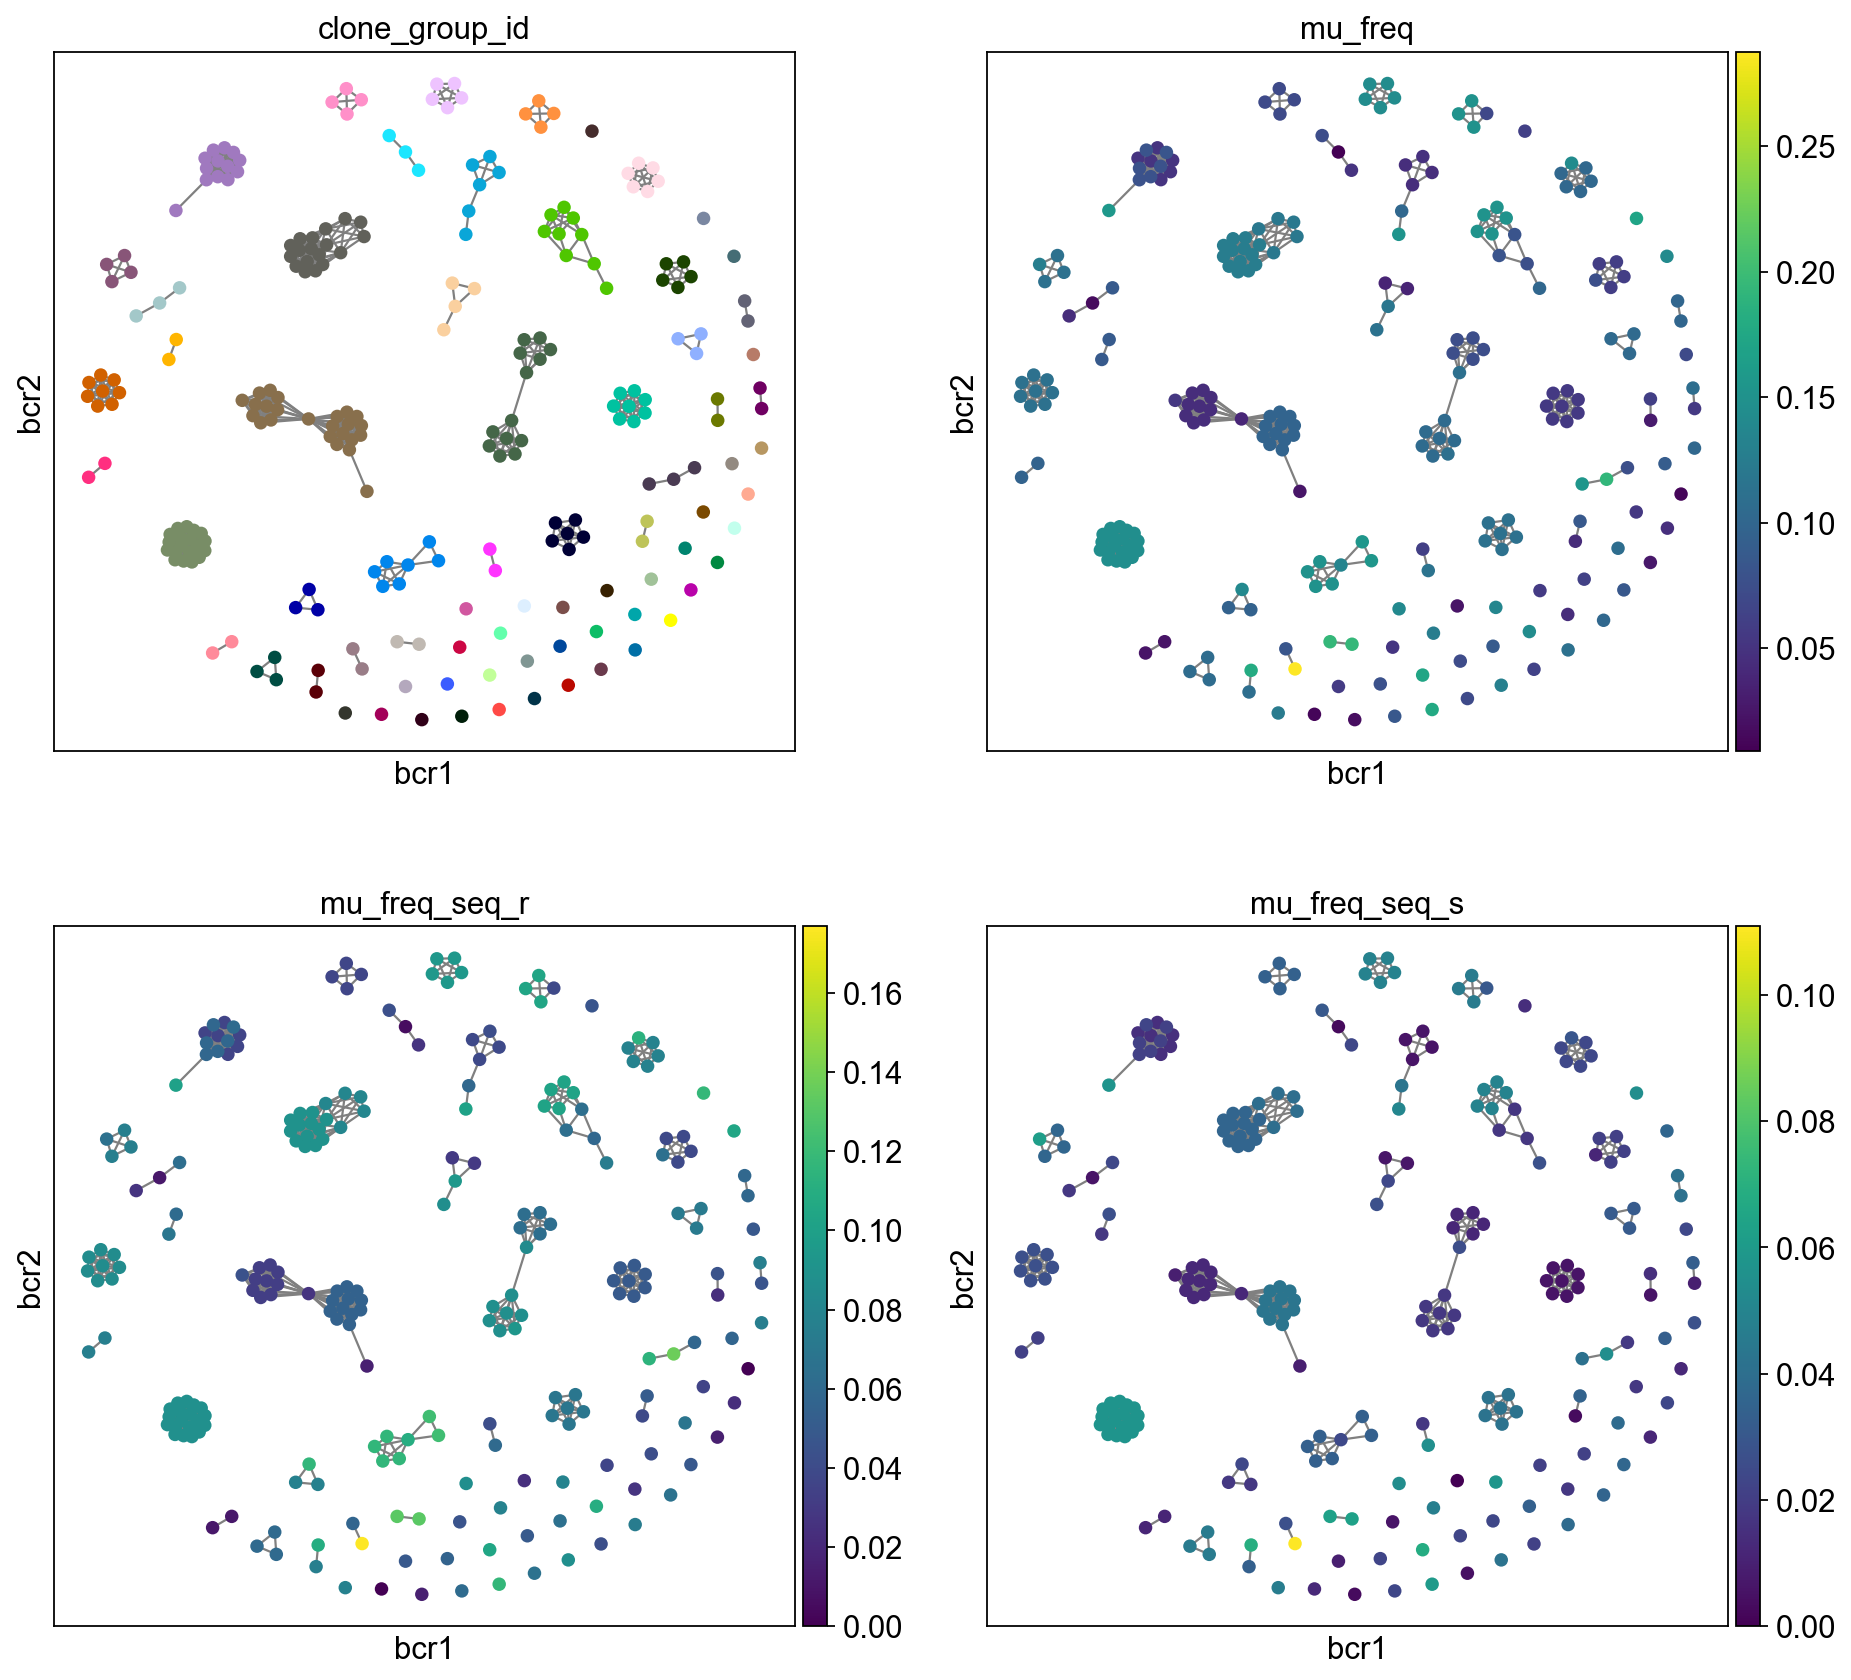

In [24]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.plot_network(adata, color = ['clone_group_id', 'mu_freq', 'mu_freq_seq_r', 'mu_freq_seq_s'], ncols = 2, legend_loc = 'none', legend_fontoutline=3, edges_width = 1)

Hurray! That's all I have got to for now. 

There are some features I will eventually want to implement in the future; for example, I want to expand the plotting modules to get some other visualization methods like barplots and spectratype plots, analyse lineage trajectories and also come up with methods to summarise the network differences between samples, but that's for another day.

Let me know if you have any ideas at [kt16@sanger.ac.uk] and I can try and see if i can implement it or we can work something out to collaborate on! See you for now!